In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [23]:
data = pd.read_pickle('../data/combined_19-09-2019.pkl')
data.shape

(8935, 43)

In [45]:
data = pd.read_pickle('../data/songkick_19-09-2019.pkl')
data

,sk_popularity,last_time_played,days_since_last_played,total_times_played_locally
idx,,,,
1.0,NaN,NaN,NaN,0.0
2.0,NaN,NaN,NaN,0.0
3.0,NaN,NaN,NaN,0.0
4.0,NaN,NaN,NaN,0.0
5.0,NaN,NaN,NaN,0.0
...,...,...,...,...
10755.0,NaN,NaN,NaN,0.0
10759.0,NaN,NaN,NaN,0.0
10798.0,NaN,NaN,NaN,0.0


In [59]:
import pickle
data_sk = pickle.load(open('../src/modeling/temp_sk.pkl','rb'))
data_sk.shape[0]

712

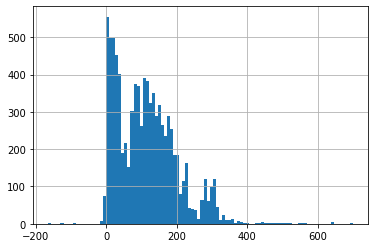

In [29]:
data = pd.read_pickle('../data/combined_19-09-2019.pkl')
data['days_on_sale'].hist(bins=100)

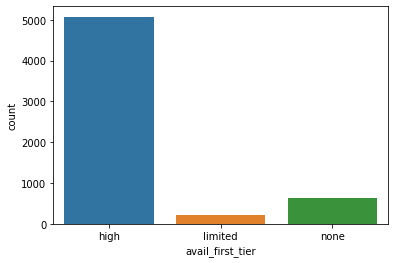

In [24]:
sns.countplot(x='avail_first_tier',data=data)
plt.show()
#Limited and none can be grouped together, and unknown should be dropped.

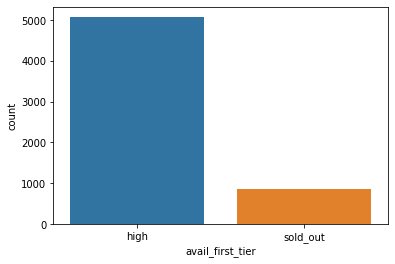

In [31]:
data.loc[data['avail_first_tier']=='limited','avail_first_tier'] = 'none'
data.loc[data['avail_first_tier']=='none','avail_first_tier'] = 'sold_out'
sns.countplot(x='avail_first_tier',data=data)
plt.show()

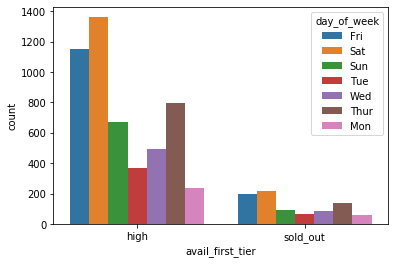

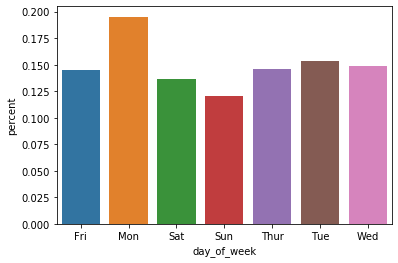

In [32]:
sns.countplot(x='avail_first_tier', hue='day_of_week', data=data)
plt.show()

data_per_weekday_and_type = data.groupby(['avail_first_tier','day_of_week']).count()['ticketmaster_event_id']
data_per_weekday_and_type.name = 'count'
data_per_weekday_and_type = data_per_weekday_and_type.reset_index()
data_per_weekday = data_per_weekday_and_type.reset_index().groupby('day_of_week').sum().reset_index()
data_per_weekday = data_per_weekday.rename({'count':'total'}, axis=1)
counts = pd.merge(data_per_weekday_and_type, data_per_weekday, on='day_of_week')
counts['percent'] = counts['count']/counts['total']
sns.barplot(x='day_of_week', y='percent', data=counts.loc[counts['avail_first_tier']=='sold_out',:])
plt.show()

The lower plot is by percent availability compared to total. We can see that sat and fri concerts sell out more readily (more sold out compared to others, less 'high')

In [33]:
#Lets make a new variable of "weekend vs weekday":
data['mon_event'] = data['day_of_week'].isin(['Mon'])
data['weekend_event'] = data['day_of_week'].isin(['Sat','Sun'])

# nans for time_of_day 0.0
# nans for population 14.224958030218243
      time_of_day population
1              20      16856
2              20      91277
3              20     182597
4              20      91277
5              20      52824
...           ...        ...
10198          19      11795
10245          19      99416
10292          19     317136
10569          19     377407
10810          20     317136

[7664 rows x 2 columns]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

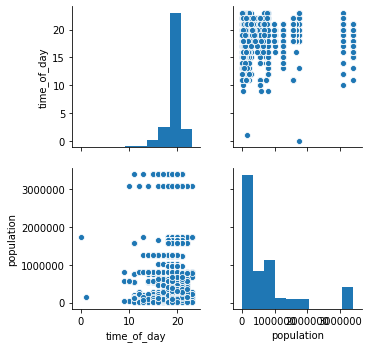

In [43]:
cont_IVs = ['time_of_day','population'] #sk_popularity, days_since_last_played
cat_IVs = ['weekend_event','mon_event']
IVs = cont_IVs + cat_IVs
for IV in cont_IVs:
    print('# nans for '+IV, 100*sum(data[IV].isna())/data.shape[0])
    plt.figure()
print(data[cont_IVs].dropna())
sns.pairplot(data[cont_IVs].dropna())

In [44]:
%matplotlib inline
data = data.loc[data['time_of_day'] != 'none',:]
IVs = ['weekend_event','time_of_day','days_since_last_played','sk_popularity','population']
DV = ['avail_first_tier']
clean_data = data[IVs].dropna()
clean_data = clean_data.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis=1)
_=sns.heatmap(clean_data.corr(), annot=True, fmt = ".2f", cmap = "viridis")
plt.tight_layout()
plt.show()


ValueError: zero-size array to reduction operation minimum which has no identity

Its very interesting that the time on sale is correlated with the population!
This must be something the ticketing venues do on purpose, or it could be a function of the larger venues or more options available?

In [194]:
# split data into training and testing sets
from sklearn.model_selection import train_test_split
clean_data = data[IVs+DV].dropna()
X=clean_data[IVs]
y=clean_data[DV]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Length of train set: \t %f' % len(X_train))
print('Length of test set: \t %f\n' % len(X_test))

Length of train set: 	 184.000000
Length of test set: 	 46.000000



In [195]:
from sklearn.ensemble import RandomForestClassifier
import pickle
model = RandomForestClassifier()
model.fit(X_train, y_train)
pickle.dump((model, IVs, DV), open('../models/random_forest_19-09-2019.pkl','wb'))

C:\Users\bdyet\Anaconda3\envs\insight\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\bdyet\Anaconda3\envs\insight\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [197]:
from sklearn.linear_model import LogisticRegression
import pickle
model = LogisticRegression()
model.fit(X_train, y_train)
pickle.dump((model, IVs, DV), open('../models/random_forest_19-09-2019.pkl','wb'))

C:\Users\bdyet\Anaconda3\envs\insight\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\bdyet\Anaconda3\envs\insight\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validate model

Accuracy: 0.695652

Performance

              precision    recall  f1-score   support

        high       0.70      1.00      0.82        32
    sold_out       0.00      0.00      0.00        14

    accuracy                           0.70        46
   macro avg       0.35      0.50      0.41        46
weighted avg       0.48      0.70      0.57        46

Confusion Matrix

[[32  0]
 [14  0]]


C:\Users\bdyet\Anaconda3\envs\insight\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


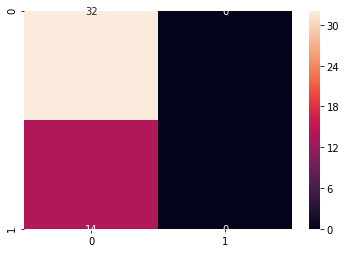

In [202]:
print('Validate model\n')
ytest_true, ytest_pred = np.asarray(y_test), model.predict(X_test)
ytest_true= [x for xs in np.array(ytest_true) for x in xs]
ytest_true_prob, ytest_pred_prob = y_test, model.predict_proba(X_test)[:, 1] # take pred of being 1

# accuracy
print('Accuracy: %f\n' % model.score(X_test, y_test))

# classification report
print('Performance\n')
from sklearn.metrics import classification_report
print(classification_report(ytest_true, ytest_pred))

# confusion matrix
print('Confusion Matrix\n')
from sklearn.metrics import confusion_matrix
_=cm=confusion_matrix(ytest_true, ytest_pred)
_=sns.heatmap(cm,annot=True,fmt="d")
print(cm)

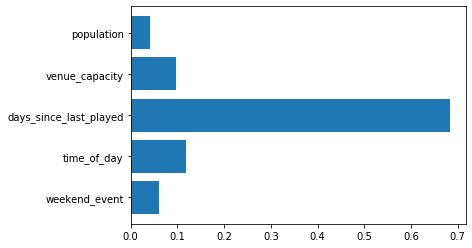

In [205]:
# view feature importance
def f_importances(coef, names):
    plt.barh(range(len(names)), coef, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
f_importances(model.feature_importances_, IVs)